# **Ouroboros EEG-fMRI NF: Predicting EEG activity, fMRI activity and NF scores**

#### Version: 28th October 2022

==============================================================================================

Project developed by Maël Donoso, Ph.D. in Cognitive and Computational Neuroscience. Affiliations: Ouroboros Neurotechnologies (https://ouroboros-neurotechnologies.com/), Institut Lémanique du Cerveau (https://institut-cerveau.ch/), Policlinique Ostéopathique de Lausanne (https://policlinique-osteopathique-lausanne.ch/). 

==============================================================================================

This project is presented through six Notebooks:

*01: Data Analysis*

*02: Classification* (all classification models except neural networks)

*03: Neural Networks*

*04: Regression on fMRI Data*

***05: Regression on EEG Data***

*06: Results*

==============================================================================================

### Notebook 05

# **Regression on EEG data**

## **1. Introduction to Regression on EEG data**

### 1.1 Objective

The objective of this project is to **explore several ways to apply machine learning models to a given EEG-fMRI NF dataset, and to evaluate which ones result in interesting predictions**. In this Notebook, we will evaluate whether EEG data can be used to predict fMRI data, EEG NF scores and fMRI NF scores. In a sense, predicting EEG NF scores will be a control experiment, since EEG data was directly used by the authors of the dataset to compute the EEG NF scores in the first place. On the other hand, the fMRI NF scores were computed independently. 

### 1.2 Models

We will use several regression models and fine-tune their hyperparameters when relevant: **linear regression**, **regression with Huber loss**, **Ridge regression**. For the fine-tuning, we will use a grid search approach, and store the test score as well as the value of the best hyperparameter found. The baseline will be a model that predicts the mean value from the train set. 

### 1.3 Data import

Here we import the **EEG and fMRI data**. For the latter, we store the data in dictionaries. 

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Define the raw data path. 
data_path = '../ouroboros_eeg-fmri_nf_raw_data/'

# Define the preprocessed data path. 
preprocessed_data_path = '../ouroboros_eeg-fmri_nf_preprocessed_data/'

# Define the results path. If empty, the results will be saved in the current directory. 
results_path = ''

In [3]:
# Define the list of subjects. 
subjects = []

for subject_index in range(10):
    if subject_index < 9:
        subjects.append('sub-xp10' + str(subject_index + 1))
    else:
        subjects.append('sub-xp1' + str(subject_index + 1))

print(subjects)

['sub-xp101', 'sub-xp102', 'sub-xp103', 'sub-xp104', 'sub-xp105', 'sub-xp106', 'sub-xp107', 'sub-xp108', 'sub-xp109', 'sub-xp110']


In [4]:
# Load the EEG predictors. 
with open(preprocessed_data_path + 'predictors_EEG_200_samples.p', 'rb') as file:
    predictors_EEG_200_samples = pickle.load(file)
with open(preprocessed_data_path + 'predictors_EEG_1600_samples.p', 'rb') as file:
    predictors_EEG_1600_samples = pickle.load(file)
with open(preprocessed_data_path + 'predictors_EEG_single_subject_all_channels_200_samples.p', 'rb') as file:
    predictors_EEG_single_subject_all_channels_200_samples = pickle.load(file)
with open(preprocessed_data_path + 'predictors_EEG_single_subject_all_channels_1600_samples.p', 'rb') as file:
    predictors_EEG_single_subject_all_channels_1600_samples = pickle.load(file)

In [5]:
# Load the fMRI data, and store the data in dictionaries. 
predictors_fMRI = dict()
predictors_fMRI_r2 = dict()
predictors_fMRI_r3 = dict()

# Iterate through all subjects. 
counter = 1
for subject_index in subjects:
    
    # Display current step. 
    print('Starting subject ' + str(counter) + ' / ' + str(len(subjects)))
    
    # Load fMRI data with the original voxel size. 
    with np.load(preprocessed_data_path + 'predictors_fMRI.npz', allow_pickle = False) as npz_file:
        predictors_fMRI[subject_index] = npz_file['sub_' + str(counter)]
    
    # Load fMRI data with the voxel size rescaling by a factor 2. 
    with np.load(preprocessed_data_path + 'predictors_fMRI_r2.npz', allow_pickle = False) as npz_file:
        predictors_fMRI_r2[subject_index] = npz_file['sub_' + str(counter)]
        
    # Load fMRI data with the voxel size rescaling by a factor 3. 
    with np.load(preprocessed_data_path + 'predictors_fMRI_r3.npz', allow_pickle = False) as npz_file:
        predictors_fMRI_r3[subject_index] = npz_file['sub_' + str(counter)]
        
    # Increment. 
    counter += 1

Starting subject 1 / 10
Starting subject 2 / 10
Starting subject 3 / 10
Starting subject 4 / 10
Starting subject 5 / 10
Starting subject 6 / 10
Starting subject 7 / 10
Starting subject 8 / 10
Starting subject 9 / 10
Starting subject 10 / 10


In [6]:
# Determine the proportion of the test set for the classification models. 
test_set_proportion = 0.2

## **2. Preliminary steps**

### **2.1 Define functions**

In the following cells, we define a series of **functions to run regression models and display the results**. 

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

In [8]:
# Define the Mean Squared Error function. 
def MSE(y, y_pred):
    return np.mean(np.square(y - y_pred))

In [9]:
# Define the Mean Absolute Error function. 
def MAE(y, y_pred):
    return np.mean(np.abs(y - y_pred))

In [10]:
# Define the Residual Sum of Squares function. 
def RSS(y, y_pred):
    return np.sum(np.square(y - y_pred))

In [11]:
# Define a function to run a regression model. 
def regression_model(Linear_Model, X_tr, X_te, y_tr, y_te, display_results = True, return_rank = False):
    
    # Fit the regression model and compute predictions. 
    lm = Linear_Model # LinearRegression(), HuberRegressor(), Ridge(), Lasso()
    lm.fit(X_tr, y_tr)
    y_pred_lm = lm.predict(X_te)
    
    # Compute the MSE, MAE and RSS measures. 
    mse_lm = MSE(y_te, y_pred_lm)
    mae_lm = MAE(y_te, y_pred_lm)
    rss_lm = RSS(y_te, y_pred_lm)
    if display_results == True:
        print('MSE:', mse_lm)
        print('MAE:', mae_lm)
        print('RSS:', rss_lm)

    # Compute the R^2 measure. 
    r2_lm = 1 - (rss_lm / rss_baseline)
    if display_results == True:
        print('R^2: ' + str(r2_lm))
        
    # Retrieve the rank. 
    if return_rank == True:
        rank = lm.rank_
    else:
        rank = None
    
    return y_pred_lm, mse_lm, mae_lm, rss_lm, r2_lm, lm.coef_, rank

In [12]:
# Define a function to fine-tune a Ridge or Lasso regression. 
def fine_tune_ridge_or_lasso(Linear_Model, X_tr, X_te, y_tr, y_te, alpha_values):
    
    # Create a list to store the results. 
    gs_results = []
    counter = 0

    # Fine-tune the regression model with a grid search. 
    for alpha in alpha_values:
        
        # Display step. 
        print('Starting step ' + str(counter) + ' / ' + str(len(alpha_values)))
        
        # Iterate. 
        for run_idx in range(5):
            
            # Create Ridge or Lasso regression. 
            lm = Linear_Model(alpha = alpha, max_iter = 20)

            # Split into train / valid sets. 
            X_tr2, X_va, y_tr2, y_va = train_test_split(
                X_tr, y_tr, test_size = 0.2, random_state = run_idx)

            # Fit the model. 
            lm.fit(X_tr2, y_tr2)

            # Save alpha value and model performance on train and validaton sets. 
            gs_results.append({
                'alpha': alpha,
                'train_mse': MSE(y_tr2, lm.predict(X_tr2)),
                'valid_mse': MSE(y_va, lm.predict(X_va)),
            })
            
        # Increment. 
        counter += 1
            
    return gs_results

In [13]:
# Define a function to display the results of the Ridge or Lasso regression fine-tuning. 
def display_ridge_or_lasso_fine_tuning(gs_results, alpha_values):
    
    # Convert results to DataFrame. 
    gs_results = pd.DataFrame(gs_results)

    # Group results by alpha value. 
    grouped = gs_results.groupby('alpha')

    # Compute train / valid mean scores with std. 
    mean_tr = grouped.train_mse.mean()
    mean_va = grouped.valid_mse.mean()
    std_tr = grouped.train_mse.std()
    std_va = grouped.valid_mse.std()

    # Plot the validation curves. 
    plt.plot(np.log10(alpha_values), mean_tr, color = 'blue', label = 'train curve')
    plt.plot(np.log10(alpha_values), mean_va, color = 'green', label = 'valid curve')

    # Mark best alpha value. 
    best_alpha = mean_va.idxmin()
    plt.scatter(np.log10(best_alpha), mean_va.min(), marker = 'x', c = 'green', zorder = 10)

    # Quantify variance with ±std curves. 
    plt.fill_between(np.log10(alpha_values), mean_tr - std_tr, mean_tr + std_tr, color = 'blue', alpha = 0.2)
    plt.fill_between(np.log10(alpha_values), mean_va - std_va, mean_va + std_va, color = 'green', alpha = 0.2)

    # Add title and labels. 
    plt.title('Best alpha: {:.2e} - MSE: {:.4f}'.format(best_alpha, mean_va.min()))
    plt.xlabel('$log_{10}(alpha)$')
    plt.ylabel('MSE')
    plt.legend()
    plt.show()
    
    return best_alpha

In [14]:
# Define a function for mapping the coefficients from the regression model to the 3D brain image. 
def create_coefficients_image(non_nan_indexes, coef):
    
    # Create a NumPy array with the appropriate shape. 
    coefficients_image = np.zeros(non_nan_indexes.shape)
    coefficients_image[:] = np.nan

    # Fill in this array with the coefficients, at the indexes corresponding to non-NaN values. 
    coefficients_image[non_nan_indexes] = coef
    
    return coefficients_image

In [15]:
# Define a function to return the middle sections of an image data array. 
def middle_sections(image_data):
    return tuple((np.array(image_data[:, :, :].shape) / 2).astype(int))

In [16]:
# Define a function to display sections of an image through the sagittal, coronal and axial views, using the middle sections coordinates. 
def display_fMRI_image(image_data, middle_coord, scan = 0, colormap = 'summer'):
    fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 5))
    axes[0].imshow(image_data[middle_coord[0], :, :, scan].T, origin = 'lower', cmap = colormap)
    axes[0].set_title('Sagittal view')
    axes[1].imshow(image_data[:, middle_coord[1], :, scan].T, origin = 'lower', cmap = colormap)
    axes[1].set_title('Coronal view')
    axes[2].imshow(image_data[:, :, middle_coord[2], scan], origin = 'lower', cmap = colormap)
    axes[2].set_title('Axial view');

In [17]:
# Define a function to display the position of a voxel or cluster, with one image as background. 
def display_voxel_or_cluster_position(voxel_index, background_image, image_data_shape):
    fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 4))

    # Sagittal view. 
    axes[0].imshow(background_image[voxel_index[0], :, :].T, origin = 'lower')
    axes[0].axhline(voxel_index[2], 0, image_data_shape[1], color = 'yellow') # Horizontal line through coronal view. 
    axes[0].axvline(voxel_index[1], 0, image_data_shape[2], color = 'yellow') # Vertical line through axial view. 
    axes[0].scatter(voxel_index[1], voxel_index[2], marker = 'o', c = 'white')
    axes[0].set_title('Sagittal view')

    # Coronal view. 
    axes[1].imshow(background_image[:, voxel_index[1], :].T, origin = 'lower')
    axes[1].axhline(voxel_index[2], 0, image_data_shape[0], color = 'yellow') # Horizontal line through sagittal view. 
    axes[1].axvline(voxel_index[0], 0, image_data_shape[2], color = 'yellow') # Vertical line through axial view. 
    axes[1].scatter(voxel_index[0], voxel_index[2], marker = 'o', c = 'white')
    axes[1].set_title('Coronal view')

    # Axial view. 
    axes[2].imshow(background_image[:, :, voxel_index[2]], origin = 'lower')
    axes[2].axhline(voxel_index[0], 0, image_data_shape[1], color = 'yellow') # Horizontal line through coronal view. 
    axes[2].axvline(voxel_index[1], 0, image_data_shape[0], color = 'yellow') # Vertical line through sagittal view. 
    axes[2].scatter(voxel_index[1], voxel_index[0], marker = 'o', c = 'white')
    axes[2].set_title('Axial view')
    plt.show();

### **2.2 Prepare the fMRI data**

In the following cells, we **prepare the preprocessed fMRI data for the regression models**. In this step, we flatten the 3D brain images and remove all NaN values. Nevertheless, we keep the position of non-NaN voxels from the original 3D image, in order to be able to reconstruct the 3D structure if necessary. 

In [18]:
# Define a function to flatten the 3D brain images and remove all NaN values. 
def flatten_preprocessed_fMRI_data(predictors_fMRI):
    
    # Create new dictionaries to store the formatted fMRI data and the non-NaN indexes. 
    predictors_fMRI_flatten = dict()
    non_nan_indexes_fMRI = dict()

    # Iterate through all subjects. 
    for subject_index in subjects:

        # Display current step. 
        print('Starting subject ' + subject_index)

        # Load the data, and retrieve the number and position of non-NaN voxels per scan. 
        image_data = predictors_fMRI[subject_index]
        non_nan_indexes = ~np.isnan(image_data[:, :, :, 0])
        nb_non_nan = np.sum(non_nan_indexes)

        # Retrieve the number of scans, then create a NumPy array with one row per scan and one column per non-NaN voxel. 
        nb_scans = image_data.shape[3]
        formatted_data = np.empty((nb_scans, nb_non_nan))

        # Fill in the array. 
        for scan in range(nb_scans):
            flatten_image = image_data[:, :, :, scan].flatten()
            flatten_image = flatten_image[~np.isnan(flatten_image)]
            formatted_data[scan, :] = flatten_image

        # Fill in the dictionary. 
        predictors_fMRI_flatten[subject_index] = formatted_data
        non_nan_indexes_fMRI[subject_index] = non_nan_indexes
        
    return predictors_fMRI_flatten, non_nan_indexes_fMRI

In [19]:
# Flatten the preprocessed fMRI data with the original voxel size. 
predictors_fMRI_flatten, non_nan_indexes_fMRI = flatten_preprocessed_fMRI_data(predictors_fMRI)

Starting subject sub-xp101
Starting subject sub-xp102
Starting subject sub-xp103
Starting subject sub-xp104
Starting subject sub-xp105
Starting subject sub-xp106
Starting subject sub-xp107
Starting subject sub-xp108
Starting subject sub-xp109
Starting subject sub-xp110


In [20]:
# Flatten the preprocessed fMRI data with the voxel size rescaling by a factor 2. 
predictors_fMRI_flatten_r2, non_nan_indexes_fMRI_r2 = flatten_preprocessed_fMRI_data(predictors_fMRI_r2)

Starting subject sub-xp101
Starting subject sub-xp102
Starting subject sub-xp103
Starting subject sub-xp104
Starting subject sub-xp105
Starting subject sub-xp106
Starting subject sub-xp107
Starting subject sub-xp108
Starting subject sub-xp109
Starting subject sub-xp110


In [21]:
# Flatten the preprocessed fMRI data with the voxel size rescaling by a factor 3. 
predictors_fMRI_flatten_r3, non_nan_indexes_fMRI_r3 = flatten_preprocessed_fMRI_data(predictors_fMRI_r3)

Starting subject sub-xp101
Starting subject sub-xp102
Starting subject sub-xp103
Starting subject sub-xp104
Starting subject sub-xp105
Starting subject sub-xp106
Starting subject sub-xp107
Starting subject sub-xp108
Starting subject sub-xp109
Starting subject sub-xp110


## **3. Regression on a single subject, fMRI data prediction**

### **3.1 Target: the peak voxel**

In the following cells, we **fit and compute predictions from a linear regression, a regression with Huber loss and a Ridge regression** for a single subject, using the value of the peak voxel as the target. We define the peak voxel as the voxel showing the highest mean value across all scans. For the Ridge regression, we fine-tune the alpha parameter, which corresponds to the regularization strength. 

In [22]:
# Define an example subject. 
subject_index = subjects[0]

# Define the voxel size rescaling factor to be used. 1: original voxel size. 2: factor 2. 3: factor 3. 
rescaling_factor = 1

In [23]:
# Define the features and targets variables. 
X = predictors_EEG_200_samples[subject_index]
if rescaling_factor == 1:
    Y = predictors_fMRI_flatten[subject_index]
    non_nan_indexes = non_nan_indexes_fMRI[subject_index]
elif rescaling_factor == 2:
    Y = predictors_fMRI_flatten_r2[subject_index]
    non_nan_indexes = non_nan_indexes_fMRI_r2[subject_index]
elif rescaling_factor == 3:
    Y = predictors_fMRI_flatten_r3[subject_index]
    non_nan_indexes = non_nan_indexes_fMRI_r3[subject_index]
print('X:', X.shape)
print('Y:', Y.shape)
print('X:', type(X))
print('Y:', type(Y))

X: (200, 5)
Y: (200, 100674)
X: <class 'numpy.ndarray'>
Y: <class 'numpy.ndarray'>


In [24]:
# Retrieve the maximum and minimum value in all the targets variables. 
print('Minimum target value: ' + str(Y.min()))
print('Maximum target value: ' + str(Y.max()))

Minimum target value: 0.0
Maximum target value: 2129.0


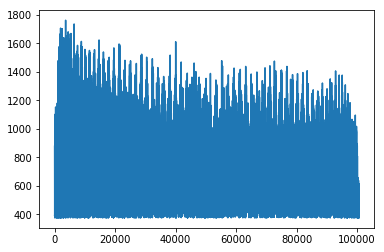

In [25]:
# Display the mean value per voxel, averaged across all scans. 
plt.plot(Y.mean(axis = 0));

In [26]:
# Define the peak voxel as the voxel with the highest mean value across all scans. 
y = Y[:, Y.mean(axis = 0).argmax()]
print('Peak voxel values per scan: ' + str(y))
print('Mean peak voxel value: ' + str(y.mean()))

Peak voxel values per scan: [1791. 1776. 1769. 1698. 1821. 1735. 1766. 1765. 1787. 1771. 1768. 1755.
 1781. 1750. 1802. 1764. 1780. 1742. 1743. 1792. 1778. 1815. 1738. 1805.
 1779. 1740. 1779. 1835. 1784. 1793. 1761. 1767. 1714. 1756. 1793. 1797.
 1753. 1770. 1769. 1776. 1754. 1819. 1790. 1766. 1761. 1779. 1776. 1781.
 1807. 1764. 1776. 1808. 1798. 1793. 1789. 1766. 1777. 1775. 1788. 1740.
 1806. 1781. 1798. 1819. 1758. 1833. 1780. 1779. 1811. 1801. 1773. 1738.
 1745. 1748. 1771. 1709. 1740. 1771. 1771. 1785. 1769. 1765. 1752. 1727.
 1726. 1770. 1805. 1784. 1787. 1757. 1747. 1772. 1770. 1769. 1819. 1816.
 1758. 1764. 1762. 1765. 1770. 1721. 1736. 1829. 1792. 1747. 1799. 1802.
 1789. 1755. 1805. 1783. 1732. 1784. 1779. 1737. 1795. 1751. 1773. 1776.
 1815. 1731. 1801. 1836. 1738. 1769. 1781. 1732. 1758. 1769. 1740. 1721.
 1720. 1756. 1776. 1795. 1737. 1785. 1802. 1767. 1722. 1730. 1757. 1827.
 1739. 1739. 1746. 1780. 1748. 1765. 1760. 1735. 1733. 1765. 1727. 1769.
 1739. 1750. 1746. 1787

In [27]:
# Reconstruct a 3D brain image showing the position of the peak voxel. 
peak_voxel_position_array = np.full(Y.shape[1], 0)
peak_voxel_position_array[Y.mean(axis = 0).argmax()] = 1
reconstructed_image = create_coefficients_image(non_nan_indexes, peak_voxel_position_array)

# Find the coordinates of the peak voxel. 
peak_voxel = np.unravel_index(np.nanargmax(reconstructed_image), reconstructed_image.shape)
peak_voxel

(25, 33, 23)

In [28]:
# Check that the reconstructed image contains one value equal to 1, and all the other values equal to 0. 
pd.value_counts(reconstructed_image.flatten())

0.0    100673
1.0         1
dtype: int64

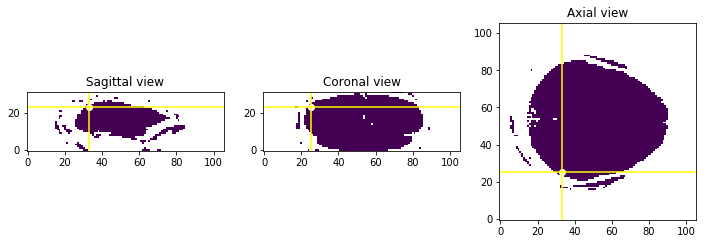

In [29]:
# Display the position of the peak voxel. 
display_voxel_or_cluster_position(peak_voxel, reconstructed_image, reconstructed_image.shape)

In [30]:
# Divide the data into a train set and a test set. 
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size = test_set_proportion)
print('Train set:')
print('X_tr:', X_tr.shape)
print('y_tr:', y_tr.shape)
print('Test set:')
print('X_te:', X_te.shape)
print('y_te:', y_te.shape)

Train set:
X_tr: (160, 5)
y_tr: (160,)
Test set:
X_te: (40, 5)
y_te: (40,)


In [31]:
# Baseline model: mean value of the peak voxel in the train set. 
mae_baseline = MAE(y_te, np.mean(y_tr))
mse_baseline = MSE(y_te, np.mean(y_tr))
rss_baseline = RSS(y_te, np.mean(y_tr))
print('MSE baseline:', mse_baseline)
print('MAE baseline:', mae_baseline)
print('RSS baseline:', rss_baseline)

MSE baseline: 1190.5339062500002
MAE baseline: 28.459375000000012
RSS baseline: 47621.35625000001


#### 3.1.1 Linear regression

In [32]:
import seaborn as sns

/Users/maeldonoso/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [33]:
# Run a linear regression. 
y_pred_lr, mse_lr, mae_lr, rss_lr, r2_lr, coef_lr, rank_lr = regression_model(
    LinearRegression(), X_tr, X_te, y_tr, y_te, return_rank = True)

MSE: 1201.904710783649
MAE: 28.22867107257195
RSS: 48076.18843134596
R^2: -0.009551012763227451


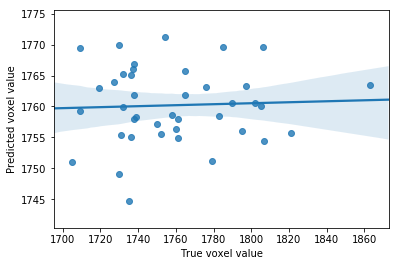

In [34]:
# Compare the true values with the predicted values. 
sns.regplot(y_te, y_pred_lr)
plt.xlabel('True voxel value')
plt.ylabel('Predicted voxel value');

In [35]:
# Compare the rank of the matrix X_tr with its shape. 
print('X_tr rank: ' + str(rank_lr))
print('X_tr shape: ' + str(X_tr.shape))

X_tr rank: 5
X_tr shape: (160, 5)


In [36]:
# Display the shape of the coefficients from the regression model. 
coef_lr.shape

(5,)

In [37]:
# Define the target bands names. 
target_bands_names = ['delta', 'theta', 'alpha', 'beta', 'high beta']

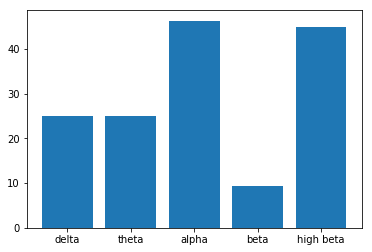

In [38]:
# Display the coefficient values. 
plt.bar(target_bands_names, coef_lr);

**Result:** Most of the time, the linear regression does not perform better than the baseline. Often, we notice a high coefficient value for the high beta bandpower. 

#### 3.1.2 Regression with Huber loss

In [39]:
# Run a regression with Huber loss. 
y_pred_huber, mse_huber, mae_huber, rss_huber, r2_huber, coef_huber, _ = regression_model(
    HuberRegressor(epsilon = 1.35), X_tr, X_te, y_tr, y_te)

MSE: 1212.4684946238326
MAE: 28.502600068634575
RSS: 48498.73978495331
R^2: -0.01842416100766342


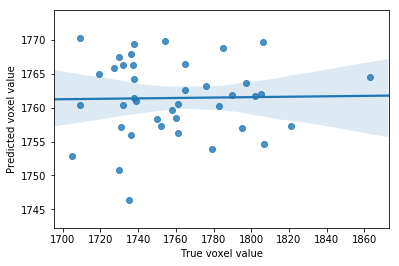

In [40]:
# Compare the true values with the predicted values. 
sns.regplot(y_te, y_pred_huber)
plt.xlabel('True voxel value')
plt.ylabel('Predicted voxel value');

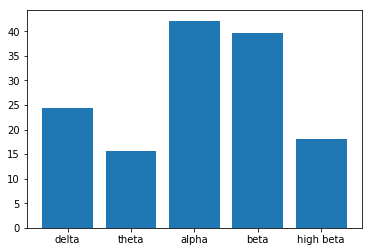

In [41]:
# Display the coefficient values. 
plt.bar(target_bands_names, coef_huber);

**Result:** Most of the time, the regression with Huber loss does not perform better than the baseline. Again, we often notice a high coefficient value for the high beta bandpower. 

#### 3.1.3 Ridge regression

In [42]:
# Define the range of alpha values to explore for the Ridge regression. 
alpha_values = np.logspace(-8, 8, num = 10)

In [43]:
# Fine-tune a Ridge regression. 
gs_results = fine_tune_ridge_or_lasso(Ridge, X_tr, X_te, y_tr, y_te, alpha_values)

Starting step 0 / 10
Starting step 1 / 10
Starting step 2 / 10
Starting step 3 / 10
Starting step 4 / 10
Starting step 5 / 10
Starting step 6 / 10
Starting step 7 / 10
Starting step 8 / 10
Starting step 9 / 10


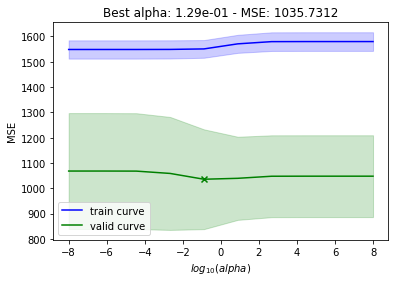

In [44]:
# Display fine-tuning results. 
best_alpha_ridge = display_ridge_or_lasso_fine_tuning(gs_results, alpha_values)

In [45]:
# Run a Ridge regression. 
y_pred_ridge, mse_ridge, mae_ridge, rss_ridge, r2_ridge, coef_ridge, _ = regression_model(
    Ridge(alpha = best_alpha_ridge), X_tr, X_te, y_tr, y_te)

MSE: 1199.3479039445617
MAE: 28.233747739770138
RSS: 47973.91615778247
R^2: -0.00740339913738719


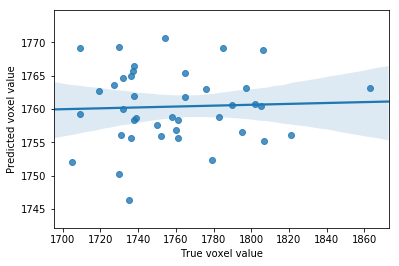

In [46]:
# Compare the true values with the predicted values. 
sns.regplot(y_te, y_pred_ridge)
plt.xlabel('True voxel value')
plt.ylabel('Predicted voxel value');

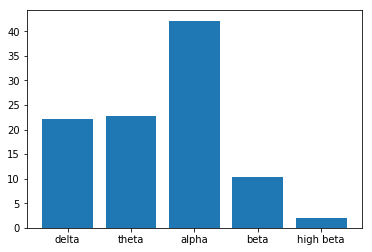

In [47]:
# Display the coefficient values. 
plt.bar(target_bands_names, coef_ridge);

**Result:** Most of the time, the Ridge regression does not perform better than the baseline. We notice the effect of regularization on the coefficient of the high beta bandpower. 

In [48]:
# Save the results into a .npz file. 
np.savez(results_path + 'regression_with_EEG_predictors_single_subject_target_fMRI_data.npz', 
         
         # Example subject. 
         subject_index = subject_index, 
         
         # Peak voxel. 
         peak_voxel = peak_voxel, 
         reconstructed_image = reconstructed_image, 
         
         # Baseline. 
         rss_baseline = rss_baseline,
         
         # Linear regression. 
         rss_lr = rss_lr, 
         r2_lr = r2_lr, 
         coef_lr = coef_lr, 
         
         # Regression with Huber loss. 
         rss_huber = rss_huber, 
         r2_huber = r2_huber, 
         coef_huber = coef_huber,
         
         # Ridge regression. 
         rss_ridge = rss_ridge, 
         r2_ridge = r2_ridge, 
         coef_ridge = coef_ridge)

### **3.2 Targets: all the voxels**

In the following cells, we **fit and compute predictions from a linear regression** for a single subject, using successively all the voxels as targets. 

In [49]:
# Define an example subject. 
subject_index = subjects[0]

# Define the voxel size rescaling factor to be used. 1: original voxel size. 2: factor 2. 3: factor 3. 
rescaling_factor = 1

In [50]:
# Define the number of voxels. 
nb_voxels = predictors_fMRI_flatten[subject_index].shape[1]
nb_voxels

100674

In [51]:
# Create a dictionary and two NumPy arrays to store the results. 
lr_all_voxels_results = dict()
lr_all_voxels_r2 = np.zeros(nb_voxels)
lr_all_voxels_sum_coef = np.zeros(5)

# Define the features and targets variables. 
X = predictors_EEG_200_samples[subject_index]
if rescaling_factor == 1:
    Y = predictors_fMRI_flatten[subject_index]
    non_nan_indexes = non_nan_indexes_fMRI[subject_index]
elif rescaling_factor == 2:
    Y = predictors_fMRI_flatten_r2[subject_index]
    non_nan_indexes = non_nan_indexes_fMRI_r2[subject_index]
elif rescaling_factor == 3:
    Y = predictors_fMRI_flatten_r3[subject_index]
    non_nan_indexes = non_nan_indexes_fMRI_r3[subject_index]

# Iterate through all voxels. 
for voxel_index in range(nb_voxels):
    
    # Display current step. 
    nb_steps = 10
    if voxel_index % int(nb_voxels / nb_steps) == 0:
        print('Starting step: ' + str(int((voxel_index + 1) // (nb_voxels / nb_steps))) + ' / 10')
    
    # Define the target voxel. 
    y = Y[:, voxel_index]
    
    # Divide the data into a train set and a test set. 
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size = test_set_proportion)
    
    # Baseline model: mean value of the alpha band in the train set. 
    rss_baseline = RSS(y_te, np.mean(y_tr))
    
    # Run a linear regression. 
    y_pred_lr, mse_lr, mae_lr, rss_lr, r2_lr, coef_lr, rank_lr = regression_model(
        LinearRegression(), X_tr, X_te, y_tr, y_te, display_results = False, return_rank = True)
    
    # Store the results in the dictionary and the two NumPy arrays. 
    lr_all_voxels_results[voxel_index] = {'y_te': y_te, 
                                          'y_pred_lr': y_pred_lr,
                                          'coef_lr': coef_lr,
                                          'rss_baseline': rss_baseline,
                                          'rss_lr': rss_lr,
                                          'r2_lr': r2_lr}
    lr_all_voxels_r2[voxel_index] = r2_lr
    lr_all_voxels_sum_coef += coef_lr

Starting step: 0 / 10
Starting step: 1 / 10
Starting step: 2 / 10
Starting step: 2 / 10
Starting step: 3 / 10
Starting step: 4 / 10
Starting step: 5 / 10
Starting step: 6 / 10
Starting step: 7 / 10
Starting step: 8 / 10
Starting step: 9 / 10


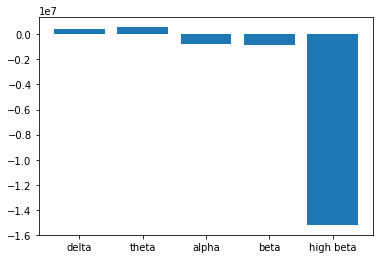

In [52]:
# Display the sum of the coefficient values across all voxels. 
plt.bar(target_bands_names, lr_all_voxels_sum_coef);

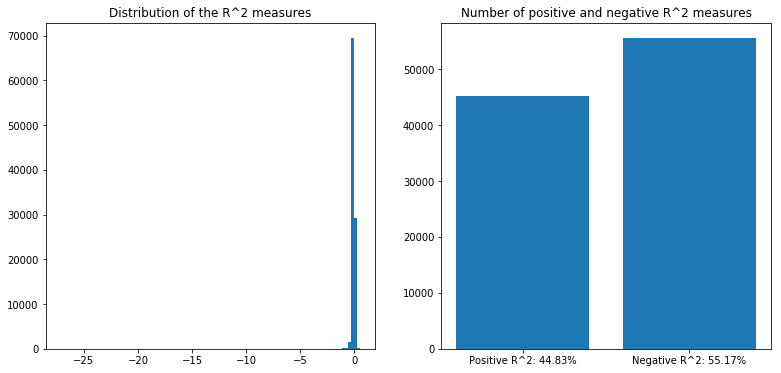

In [53]:
# Display a histogram of the predictability values of all voxels. 
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (13, 6))
axes[0].hist(lr_all_voxels_r2, bins = 100)
axes[0].set_title('Distribution of the R^2 measures')
axes[1].bar([1, 2], [np.sum(lr_all_voxels_r2 > 0), np.sum(lr_all_voxels_r2 < 0)])
axes[1].set_xticks([1, 2])
axes[1].set_xticklabels(['Positive R^2: ' + str(np.round(100 * np.sum(lr_all_voxels_r2 > 0) / len(lr_all_voxels_r2), 2)) + '%',
                         'Negative R^2: ' + str(np.round(100 * np.sum(lr_all_voxels_r2 < 0) / len(lr_all_voxels_r2), 2)) + '%'])
axes[1].set_title('Number of positive and negative R^2 measures');

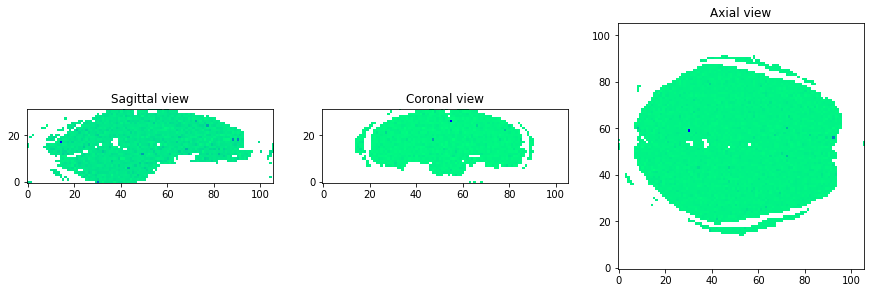

In [54]:
# Reconstruct a 3D brain image showing the R^2 measure for each voxel. 
r2_image_lr = create_coefficients_image(non_nan_indexes, lr_all_voxels_r2)

# Display the R^2 for each voxel at the middle section coordinates. 
middle_coord = middle_sections(r2_image_lr)
display_fMRI_image(r2_image_lr[:, :, :, np.newaxis], middle_coord, colormap = 'winter')

**Result:** The linear regression does not perform better than the baseline for a majority of voxels, as we can see in the distribution of the R^2 measures. In the predictability map above, there seem to be a few voxels with very low predictability. From the histogram showing the sum of coefficient values for all frequency bands, we understand that the high beta band is problematic, with strongly negative coefficient values. 

## **4. Regression on all subjects, fMRI data prediction**

In the following cells, we **fit and compute predictions from a linear regression** for all the subjects, using the peak voxel of each subject as the target. We must remember that the fMRI images are not normalized into a common template. As a consequence, most of the time, the peak voxel from one subject will not be at the same position as the peak voxel from another subject. The only thing in common is that we are dealing, for each subject, with the voxel showing the highest mean value across all scans. 

In [55]:
# Define the voxel size rescaling factor to be used. 1: original voxel size. 2: factor 2. 3: factor 3. 
rescaling_factor = 1

In [56]:
# Create a dictionary and two NumPy arrays to store the results. 
lr_all_subjects_results = dict()
lr_all_subjects_r2 = np.zeros(len(subjects))
lr_all_subjects_sum_coef = np.zeros(5)
counter = 0

# Iterate through all subjects. 
for subject_index in subjects:
    
    # Display current step. 
    print('Starting subject: ' + subject_index)
    
    # Define the features and target variables. 
    X = predictors_EEG_200_samples[subject_index]
    if rescaling_factor == 1:
        Y = predictors_fMRI_flatten[subject_index]
        non_nan_indexes = non_nan_indexes_fMRI[subject_index]
    elif rescaling_factor == 2:
        Y = predictors_fMRI_flatten_r2[subject_index]
        non_nan_indexes = non_nan_indexes_fMRI_r2[subject_index]
    elif rescaling_factor == 3:
        Y = predictors_fMRI_flatten_r3[subject_index]
        non_nan_indexes = non_nan_indexes_fMRI_r3[subject_index]
        
    # Define the peak voxel as the voxel with the highest mean value across all scans. 
    y = Y[:, Y.mean(axis = 0).argmax()]
    
    # Divide the data into a train set and a test set. 
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size = test_set_proportion)
    
    # Baseline model: mean value of the alpha band in the train set. 
    rss_baseline = RSS(y_te, np.mean(y_tr))
    
    # Run a linear regression. 
    y_pred_lr, mse_lr, mae_lr, rss_lr, r2_lr, coef_lr, rank_lr = regression_model(
        LinearRegression(), X_tr, X_te, y_tr, y_te, return_rank = True)
    print()
    
    # Reconstruct a 3D brain image showing the position of the peak voxel. 
    middle_coord = middle_sections(non_nan_indexes)
    peak_voxel_position_array = np.full(Y.shape[1], 0)
    peak_voxel_position_array[Y.mean(axis = 0).argmax()] = 1
    reconstructed_image = create_coefficients_image(non_nan_indexes, peak_voxel_position_array)

    # Find the coordinates of the peak voxel. 
    peak_voxel = np.unravel_index(np.nanargmax(reconstructed_image), reconstructed_image.shape)
    
    # Store the results in the dictionary and the two NumPy arrays. 
    lr_all_subjects_results[subject_index] = {'y_te': y_te, 
                                              'y_pred_lr': y_pred_lr,
                                              'coef_lr': coef_lr,
                                              'reconstructed_image': reconstructed_image,
                                              'middle_coord': middle_coord,
                                              'peak_voxel': peak_voxel,
                                              'rss_baseline': rss_baseline,
                                              'rss_lr': rss_lr,
                                              'r2_lr': r2_lr}
    lr_all_subjects_r2[counter] = r2_lr
    lr_all_subjects_sum_coef += coef_lr
    
    # Increment. 
    counter += 1

Starting subject: sub-xp101
MSE: 1215.8872674621578
MAE: 27.322215286413353
RSS: 48635.49069848631
R^2: -0.043690381427500036

Starting subject: sub-xp102
MSE: 3410.4782437401723
MAE: 50.521937755014264
RSS: 136419.1297496069
R^2: 0.0006101306959669373

Starting subject: sub-xp103
MSE: 3253.74128571428
MAE: 45.51527941521054
RSS: 130149.6514285712
R^2: 0.04935523199281577

Starting subject: sub-xp104
MSE: 607.9309086654121
MAE: 20.722142931627133
RSS: 24317.236346616482
R^2: -0.08706104920874824

Starting subject: sub-xp105
MSE: 3559.5621994033872
MAE: 48.37114024803289
RSS: 142382.48797613548
R^2: -0.05960258416789066

Starting subject: sub-xp106
MSE: 1950.3426582742418
MAE: 35.53632242892418
RSS: 78013.70633096967
R^2: 0.09643494822541587

Starting subject: sub-xp107
MSE: 2270.0900421250467
MAE: 37.31152358505386
RSS: 90803.60168500186
R^2: 0.04838632164613843

Starting subject: sub-xp108
MSE: 1660.8241313212984
MAE: 34.1706578807132
RSS: 66432.96525285194
R^2: -0.03687813608640589



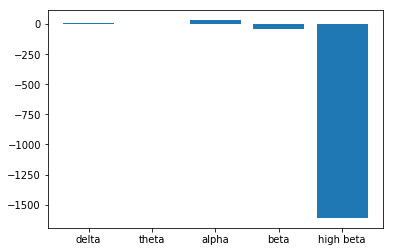

In [57]:
# Display the mean of the coefficient values for each EEG predictor, averaging all subjects. 
plt.bar(target_bands_names, (lr_all_subjects_sum_coef / len(subjects)) );

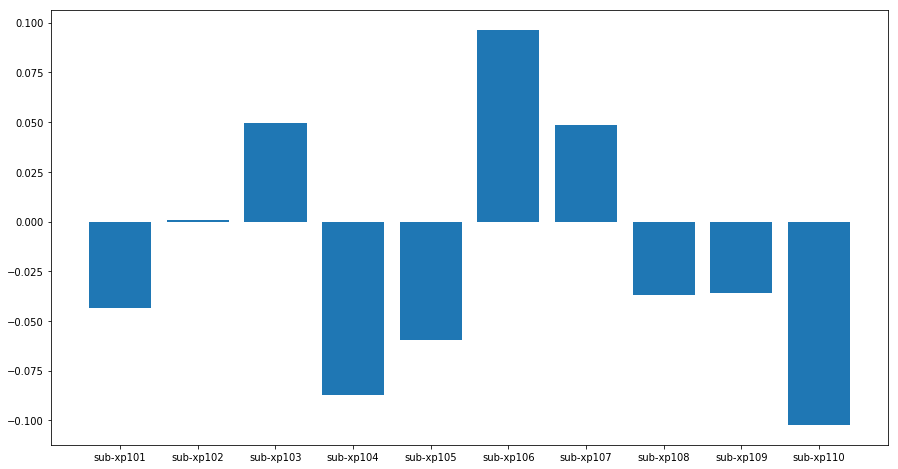

In [58]:
# Display the R^2 measure for the peak voxel of all subjects. 
plt.figure(figsize = (15, 8))
plt.bar(subjects, lr_all_subjects_r2);

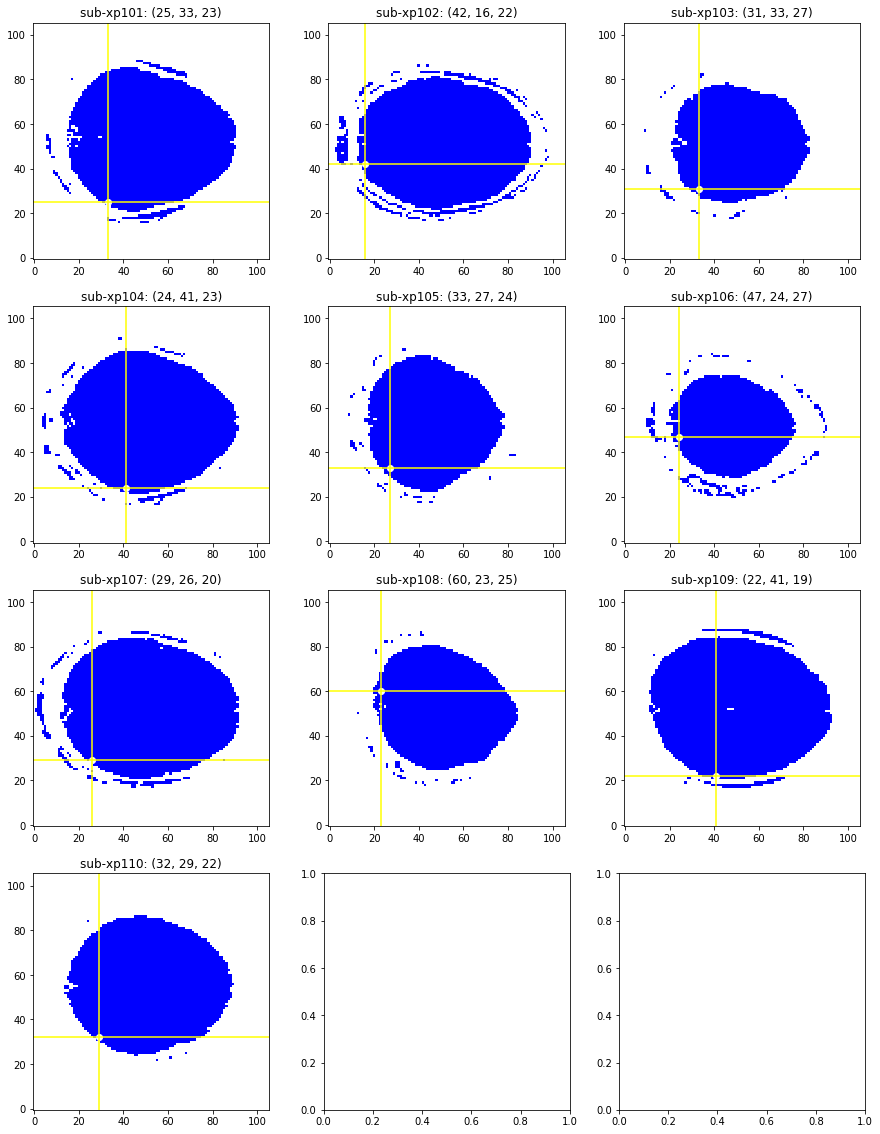

In [59]:
# Display the position of the peak voxel for all subjects. 
fig, axes = plt.subplots(nrows = 4, ncols = 3, figsize = (15, 20))
counter = 0

# Iterate through all subjects. 
for subject_index in subjects:
    
    # Compute the row and column indexes. 
    row_index = counter // 3
    column_index = counter % 3
    
    # Retrieve the reconstructed image and the peak voxel index. 
    reconstructed_image = lr_all_subjects_results[subject_index]['reconstructed_image']
    peak_voxel = lr_all_subjects_results[subject_index]['peak_voxel']
    
    # Display the graphs. 
    middle_coord = lr_all_subjects_results[subject_index]['middle_coord']
    axes[row_index, column_index].imshow(reconstructed_image[:, :, peak_voxel[2]], origin = 'lower', cmap = 'winter')
    axes[row_index, column_index].axhline(peak_voxel[0], 0, reconstructed_image.shape[1], color = 'yellow') # Horizontal line through coronal view. 
    axes[row_index, column_index].axvline(peak_voxel[1], 0, reconstructed_image.shape[0], color = 'yellow') # Vertical line through sagittal view. 
    axes[row_index, column_index].scatter(peak_voxel[1], peak_voxel[0], marker = 'o', c = 'white')
    axes[row_index, column_index].set_title(subject_index + ': ' + str(peak_voxel))
    
    # Increment. 
    counter += 1

**Result:** Most of the time, the linear regression does not perform better than the baseline for the majority of the subjects. As expected, the position of the peak voxel varies among the subjects. 

In [60]:
# Save the results into a Pickle file. 
with open(results_path + 'regression_with_EEG_predictors_all_subjects_target_fMRI_data.p', 'wb') as file:
    pickle.dump(lr_all_subjects_results, file)

## **5. Regression on all subjects, NF scores prediction**

### **5.1 Target: EEG NF scores**

In the following cells, we **fit and compute predictions from a linear regression** for all the subjects, using the EEG NF scores as the target. Since the EEG NF scores were computed with 1600 data points for the eegfmriNF run, we use the EEG bandpowers computed with a sampling of 1600 data points. 

In [61]:
import h5py

In [62]:
# Create a dictionary to store the results. 
lr_all_subjects_results = dict()
lr_all_subjects_sum_coef = np.zeros(5)

# Iterate through all subjects. 
for subject_index in subjects:
    
    # Display current step. 
    print('Starting subject: ' + subject_index)
    
    # Define the path of the .mat file for this subject, for the eegfmriNF condition. 
    mat_path = data_path + 'derivatives/' + subject_index + '/NF_eeg/d_' + subject_index + '_task-eegfmriNF_NFeeg_scores.mat'
    
    # Load the .mat file, extract the data et store the NF scores. 
    f = h5py.File(mat_path, 'r')
    mat_data = f.get('NF_eeg')
    eeg_nf_scores = np.nan_to_num(np.array(mat_data['nf_laterality']))
    
    # Define the features and target variables. 
    X = predictors_EEG_1600_samples[subject_index]
    y = eeg_nf_scores
    
    # Divide the data into a train set and a test set. 
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size = test_set_proportion)
    
    # Baseline model: mean value of the alpha band in the train set. 
    rss_baseline = RSS(y_te, np.mean(y_tr))
    
    # Run a linear regression. 
    y_pred_lr, mse_lr, mae_lr, rss_lr, r2_lr, coef_lr, rank_lr = regression_model(
        LinearRegression(), X_tr, X_te, y_tr, y_te, return_rank = True)
    print()
    
    # Store the results in the dictionary. 
    lr_all_subjects_results[subject_index] = {'y_te': y_te, 
                                              'y_pred_lr': y_pred_lr,
                                              'coef_lr': coef_lr,
                                              'rss_baseline': rss_baseline,
                                              'rss_lr': rss_lr,
                                              'r2_lr': r2_lr}
    lr_all_subjects_sum_coef += coef_lr[0, :]

Starting subject: sub-xp101
MSE: 0.04633244883443151
MAE: 0.16668195862823273
RSS: 14.826383627018082
R^2: -0.0018379261154732873

Starting subject: sub-xp102
MSE: 0.08976973953303043
MAE: 0.2454053810020122
RSS: 28.726316650569736
R^2: 0.03524619542035545

Starting subject: sub-xp103
MSE: 0.10716062101174655
MAE: 0.26370812457908765
RSS: 34.291398723758896
R^2: 0.020697990259219257

Starting subject: sub-xp104
MSE: 0.10074831654512924
MAE: 0.2591908252220169
RSS: 32.239461294441355
R^2: 0.0021430548911636205

Starting subject: sub-xp105
MSE: 0.10246033806918656
MAE: 0.2527426112085663
RSS: 32.7873081821397
R^2: 0.011208026829912399

Starting subject: sub-xp106
MSE: 0.1348402538140227
MAE: 0.3049362113376614
RSS: 43.14888122048727
R^2: 0.08932904692356647

Starting subject: sub-xp107
MSE: 0.0708240882840819
MAE: 0.22401863193284388
RSS: 22.66370825090621
R^2: 0.007616204624815381

Starting subject: sub-xp108
MSE: 0.09124938583703272
MAE: 0.246837758748332
RSS: 29.199803467850472
R^2: 0

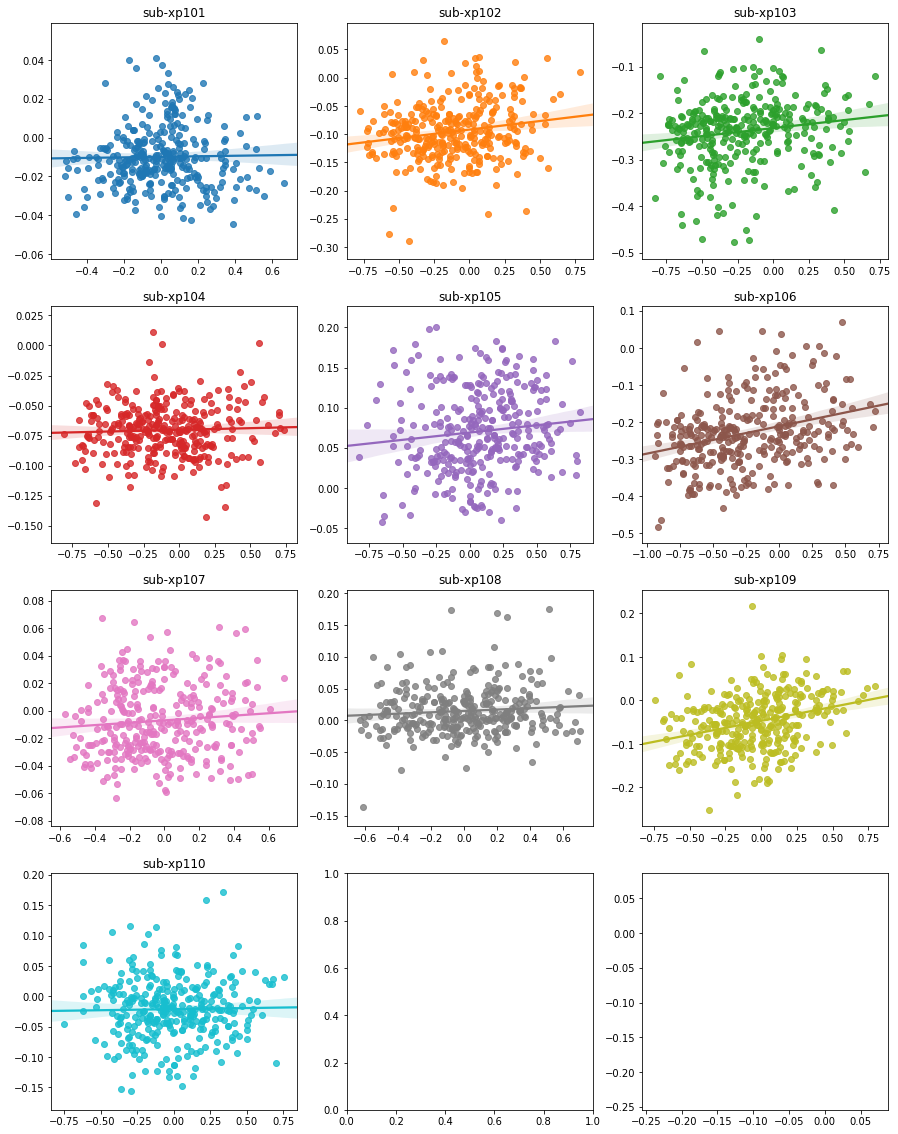

In [63]:
# Compare the true values with the predicted values, for all subjects. 
fig, axes = plt.subplots(nrows = 4, ncols = 3, figsize = (15, 20))
counter = 0

# Iterate through all subjects. 
for subject_index in subjects:
    
    # Compute the row and column indexes. 
    row_index = counter // 3
    column_index = counter % 3
    
    # Draw the graphs. 
    sns.regplot(lr_all_subjects_results[subject_index]['y_te'][:, 0], lr_all_subjects_results[subject_index]['y_pred_lr'][:, 0], ax = axes[row_index, column_index])
    axes[row_index, column_index].set_title(subject_index);
    
    # Increment. 
    counter += 1

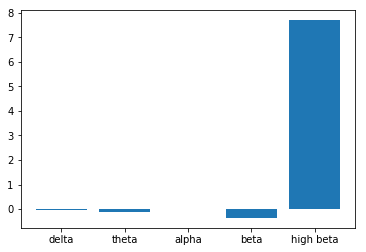

In [64]:
# Display the mean of the coefficient values for each EEG predictor, averaging all subjects. 
plt.bar(target_bands_names, (lr_all_subjects_sum_coef / len(subjects)) );

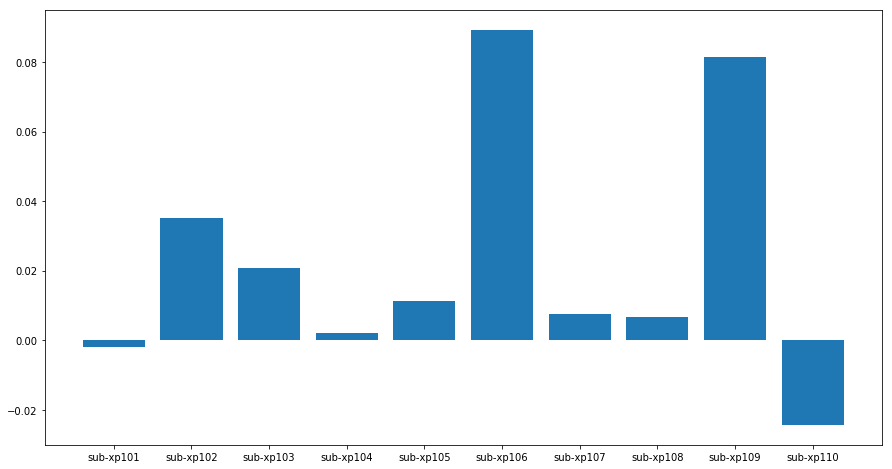

In [65]:
# Display the R^2 measure for all subjects. 
r2_lr_all_subjects = []
for subject_index in subjects:
    r2_lr_all_subjects.append(lr_all_subjects_results[subject_index]['r2_lr'])
plt.figure(figsize = (15, 8))
plt.bar(range(10), r2_lr_all_subjects, tick_label = subjects);

**Result:** The results are variable, but typically, linear regression performs better than the baseline for most of the subjects. 

In [66]:
# Save the results into a Pickle file. 
with open(results_path + 'regression_with_EEG_predictors_all_subjects_target_EEG_NF_scores.p', 'wb') as file:
    pickle.dump(lr_all_subjects_results, file)

### **5.2 Target: fMRI NF scores**

In the following cells, we **fit and compute predictions from a linear regression** for all the subjects, using the fMRI NF scores as the target. 

In [67]:
# Create a dictionary to store the results. 
lr_all_subjects_results = dict()
lr_all_subjects_sum_coef = np.zeros(5)

# Iterate through all subjects. 
for subject_index in subjects:
    
    # Display current step. 
    print('Starting subject: ' + subject_index)
    
    # Define the path of the .mat file for this subject, for the eegfmriNF condition. 
    mat_path = data_path + 'derivatives/' + subject_index + '/NF_bold/d_' + subject_index + '_task-eegfmriNF_NFbold_scores.mat'
    
    # Load the .mat file, extract the data et store the NF scores. 
    f = h5py.File(mat_path, 'r')
    mat_data = f.get('NF_bold')
    fmri_nf_scores = np.array(mat_data['nf_laterality'])
    fmri_nf_scores = fmri_nf_scores[:, 0]
    
    # Define the features and target variables. 
    X = predictors_EEG_200_samples[subject_index]
    y = fmri_nf_scores
    
    # Divide the data into a train set and a test set. 
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size = test_set_proportion)
    
    # Baseline model: mean value of the alpha band in the train set. 
    rss_baseline = RSS(y_te, np.mean(y_tr))
    
    # Run a linear regression. 
    y_pred_lr, mse_lr, mae_lr, rss_lr, r2_lr, coef_lr, rank_lr = regression_model(
        LinearRegression(), X_tr, X_te, y_tr, y_te, return_rank = True)
    print()
    
    # Store the results in the dictionary. 
    lr_all_subjects_results[subject_index] = {'y_te': y_te, 
                                              'y_pred_lr': y_pred_lr,
                                              'coef_lr': coef_lr,
                                              'rss_baseline': rss_baseline,
                                              'rss_lr': rss_lr,
                                              'r2_lr': r2_lr}
    lr_all_subjects_sum_coef += coef_lr

Starting subject: sub-xp101
MSE: 0.47076243197529966
MAE: 0.5599562187518451
RSS: 18.830497279011986
R^2: 0.01792175356059955

Starting subject: sub-xp102
MSE: 0.3436536408173502
MAE: 0.44120888113693546
RSS: 13.74614563269401
R^2: 0.027407359498509698

Starting subject: sub-xp103
MSE: 0.23763081752485612
MAE: 0.39816898542783563
RSS: 9.505232700994245
R^2: -0.027323728429789362

Starting subject: sub-xp104
MSE: 0.19121435547470367
MAE: 0.2988951125389443
RSS: 7.648574218988147
R^2: 0.03201034994191565

Starting subject: sub-xp105
MSE: 0.7779293828975711
MAE: 0.6308597365012455
RSS: 31.11717531590284
R^2: -0.2535251806480616

Starting subject: sub-xp106
MSE: 0.1964327245961301
MAE: 0.3525063726217478
RSS: 7.857308983845204
R^2: -0.0054439551881229065

Starting subject: sub-xp107
MSE: 0.8681754609407362
MAE: 0.7852021412300858
RSS: 34.72701843762945
R^2: 0.05578433089254409

Starting subject: sub-xp108
MSE: 0.16047363154867494
MAE: 0.32248745600318
RSS: 6.418945261946998
R^2: -0.0950192

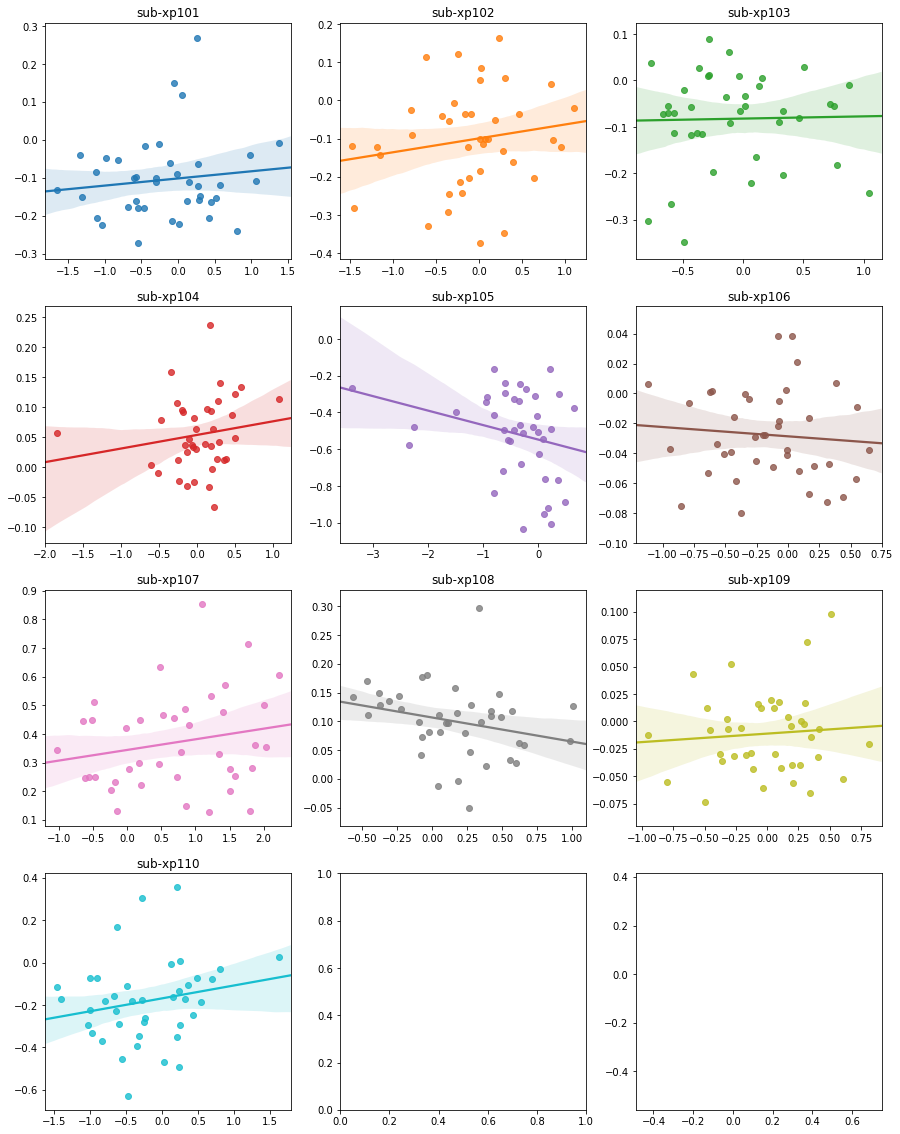

In [68]:
# Compare the true values with the predicted values, for all subjects. 
fig, axes = plt.subplots(nrows = 4, ncols = 3, figsize = (15, 20))
counter = 0

# Iterate through all subjects. 
for subject_index in subjects:
    
    # Compute the row and column indexes. 
    row_index = counter // 3
    column_index = counter % 3
    
    # Draw the graphs. 
    sns.regplot(lr_all_subjects_results[subject_index]['y_te'], lr_all_subjects_results[subject_index]['y_pred_lr'], ax = axes[row_index, column_index])
    axes[row_index, column_index].set_title(subject_index);
    
    # Increment. 
    counter += 1

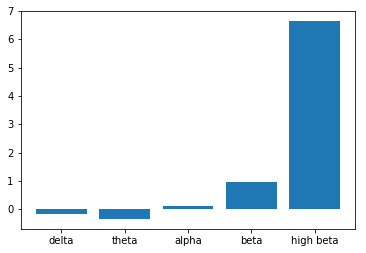

In [69]:
# Display the mean of the coefficient values for each EEG predictor, averaging all subjects. 
plt.bar(target_bands_names, (lr_all_subjects_sum_coef / len(subjects)) );

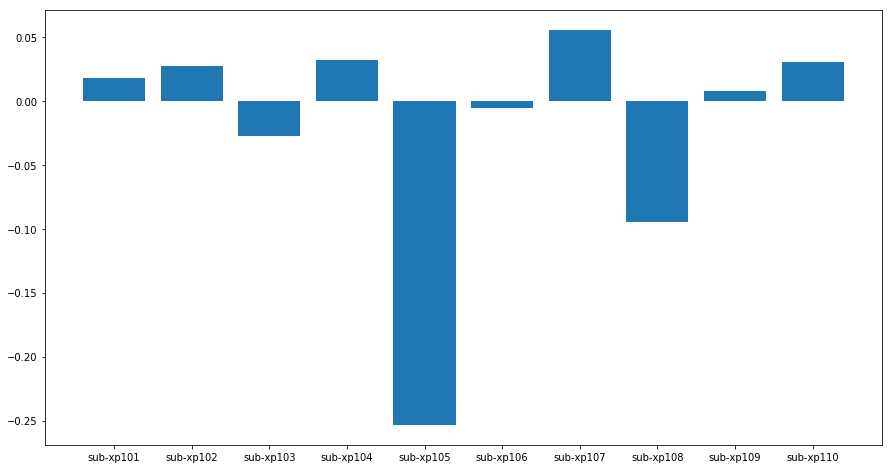

In [70]:
# Display the R^2 measure for all subjects. 
r2_lr_all_subjects = []
for subject_index in subjects:
    r2_lr_all_subjects.append(lr_all_subjects_results[subject_index]['r2_lr'])
plt.figure(figsize = (15, 8))
plt.bar(range(10), r2_lr_all_subjects, tick_label = subjects);

**Result:** The results are variable, but typically, linear regression does not perform better than the baseline for most of the subjects. 

In [71]:
# Save the results into a Pickle file. 
with open(results_path + 'regression_with_EEG_predictors_all_subjects_target_fMRI_NF_scores.p', 'wb') as file:
    pickle.dump(lr_all_subjects_results, file)